In [1]:
# Notebook header <--- Always run this cell first!
import os, json
import ruamel.yaml as yaml
import numpy as np
import matplotlib, tikzplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline

from monty.json import MontyDecoder, MontyEncoder
from ipywidgets import SelectMultiple, FloatSlider, FloatRangeSlider, SelectionSlider, Combobox
from ipywidgets import interact, fixed, jslink
from pymatgen.electronic_structure.plotter import DosPlotter
from quotas.core import QuotasCalculator

figures_dir = "../../../figures/quotas"
data_dir = "/mnt/data/mbercx/quotas"

# Load the dictionary of all the structures for which we have calculated the required properties
with open("../data/structure_dict.yaml", "r") as file:
    structure_dict = yaml.safe_load(file.read())
    
with open("../data/yield.json", "r") as file:
    yield_dict = json.loads(file.read(), cls=MontyDecoder)
    
# Define the effective ionization energies of the rare gas ions
ionization_energies = {
    "He": 24.56 - 2,
    "Ne": 21.56 - 1,
#     "Ar": 15.76 - 0.5,
#     "Kr": 12.00,
#     "Xe": 10.13
}

color0 = "#3373A8"
color1 = "#B93033"

# color0 = (0.72156862745098,0.12156862745098,0.12156862745098)
# color1 = (0.137254901960784,0.407843137254902,0.635294117647059)

# Baragiola parameters
param1=0.78
param2=-2

In [2]:
with open("../data/results.json", "r") as file:
    results_dict = json.loads(file.read(), cls=MontyDecoder)

In [3]:
total_yield_dict = {}

for ion in ionization_energies.keys():
    work_functions = []
    yields = []
    yields_np = []

    for element in yield_dict.keys():
        work_functions.extend([yield_dict[element][surface]['work_function']
                               for surface in yield_dict[element].keys()])
        yields.extend([surface[ion]["total_yield"] for surface in yield_dict[element].values()])
#         yields_np.extend([surface[ion]["total_yield"] for surface in yield_np_dict[element].values()])
        
    total_yield_dict[ion] = {
        "ionization_energy": ionization_energies[ion],
        "work_functions": work_functions,
        "yields": yields,
        "yields_no_plasmons": yields_np
    }

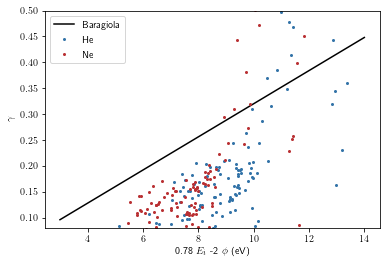

In [4]:
color_dict = {
    "He": color0,
    "Ne": color1
}

x = np.linspace(3, 14, 100)
plt.plot(x,  x*0.032, "k")

for ion, ionization_energy in ionization_energies.items():
    x_values = param2 * np.array(total_yield_dict[ion]["work_functions"]) + param1 * ionization_energy
    plt.plot(x_values, total_yield_dict[ion]["yields"], "o", color=color_dict[ion], markersize=2)
    plt.xlabel(str(param1) + r" $E_i$ " + str(param2) + r" $\phi$ (eV)")
    plt.ylabel(r"$\gamma$")

plt.legend(["Baragiola"] + list(ionization_energies.keys()))
plt.ylim([0.08, 0.5])
tikzplotlib.save(filepath=os.path.join(figures_dir, "baragiola_calc.tex"), 
                 add_axis_environment=False)

In [5]:
with open("../data/experimental_data.json", "r") as file:
    exp_spectra = json.loads(file.read(), cls=MontyDecoder)

with open("../data/yield_data.json", "r") as file:
    exp_data = json.loads(file.read(), cls=MontyDecoder)

In [6]:
total_yield_dict = {}

for ion in ["He", "Ne"]:
    work_functions = []
    yields = []

    for element in exp_spectra.keys():
        work_functions.extend([yield_dict[element][surface]['work_function']
                               for surface in yield_dict[element].keys()])
        yields.extend([exp_spectra[element][ion]["total_yield"]/1e3] * 3)
        
    total_yield_dict[ion] = {
        "ionization_energy": ionization_energies[ion],
        "work_functions": work_functions,
        "yields": yields,
    }

In [9]:
# This if for the Baragiola plot, so we don't 
# care which surface corresponds to which work function

wf_data = {
    "Ge": [5.0],
    "Si": [4.79], # , 4.71, 4.84
    "Al": [4.28, 4.36, 4.21],
    "Mg": [3.66],
    "Be": [4.98],
    "W": [4.38, 4.57, 5.31],
    "Ni": [5.28], # , 5.23, 4.64
    "Cu": [4.48] # 
}

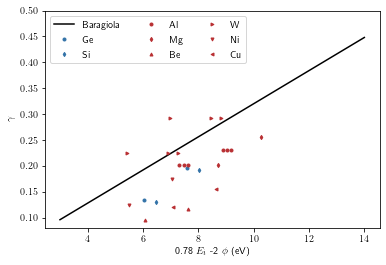

In [10]:
x = np.linspace(3, 14, 100)
plt.plot(x,  x*0.032, "k")

plot_dict = {
    "Ge": {"marker": "o", "color": color0},
    "Si": {"marker": "d", "color": color0},
    "Al": {"marker": "o", "color": color1},
    "Mg": {"marker": "d", "color": color1},
    "Be": {"marker": "^", "color": color1},
    "W": {"marker": ">", "color": color1},
    "Ni": {"marker": "v", "color": color1},
    "Cu": {"marker": "<", "color": color1}
}

for element in exp_spectra.keys(): 
    
    x_values = []
    yields = []
    
    work_functions = np.array(wf_data[element])

    for ion, ionization_energy in ionization_energies.items():
        
        x_values.extend(param2 * work_functions + param1 * np.array([ionization_energy] * len(work_functions)))
        yields.extend([exp_spectra[element][ion]["total_yield"]/1e3] * len(work_functions))
    
    plt.plot(x_values, yields, markersize=3, linestyle='', **plot_dict[element])
    
plt.xlabel(str(param1) + r" $E_i$ " + str(param2) + r" $\phi$ (eV)")
plt.ylabel(r"$\gamma$")
plt.legend(["Baragiola"] + list(exp_spectra.keys()), ncol=3, loc="upper left")
plt.ylim([0.08, 0.5])
tikzplotlib.save(filepath=os.path.join(figures_dir, "baragiola_exp.tex"), 
                 add_axis_environment=False)